# LeNet-5 from scratch

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms 

from modules.activation import SquashedTanh
from modules.criterion import MSE
from modules.init import LeCun
from modules.layer import Linear, Conv, Flatten, RBF
from modules.loader import DatasetLoader
from modules.model import RBF_Sequential
from modules.optimizer import Adam
from modules.pooling import AvgPool
from modules.constant import ASCII_BITMAP, C3_MAPPING
from modules.utils import save_model

Create a composed transform to transform the data into images in the dimension of (32, 32) and normalized the pixel values to accelerate learning 

In [2]:
composed_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

Split the dataset into training and testing data and labels

In [17]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=composed_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=composed_transform)

X_train = np.array([data[0].numpy() for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])
X_test = np.array([data[0].numpy() for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

LeNet-5 Architecture

<img src='./img/architecture.png' width=100%>

The activation function of the LeNet model <code>SquashedTanh</code> is a modification of the Tanh function with $S=\frac{2}{3}$ and $A=1.7159$

<img src='img/activation.png' width=50%>

The feature maps in layer C3 (<code>C3_MAPPING</code>) takes specific output channels from S2 according to the following table

<img src='img/mappings.png' width=50%>

The final RBF output layer which takes in <code>ASCII_BITMAP</code> as parameter is composed of feature maps of digit 0-9. 

<img src='img/ascii_mapping.png' width=50%>

During training phrase, the output of the model will be compared against the feature map of the ground truth and evaluate the loss for the sample using the <code>MSE</code> loss function, then the model parameters will be updated in backpropagation.

<img src='img/rbf_desc.png' width=50%>

In [8]:
init_method = LeCun()

model = RBF_Sequential([
    # Conv Layers
    Conv((32, 32), 128, 1, 6, 5), #c1
    AvgPool(2), #s2
    SquashedTanh(),
    Conv((14, 14), 128, 6, 16, 5, mapping=C3_MAPPING), #c3
    AvgPool(2), #s4
    SquashedTanh(), 
    Conv((5, 5), 128, 16, 120, 5), #c5
    SquashedTanh(),
    
    # FC Layers
    Flatten(),
    Linear(120, 84, init_method), #f6
    SquashedTanh(),
    RBF(ASCII_BITMAP) #output
])

The loss function used in this model is the simplest <code>MSE</code> proposed in the paper (without MAP)

<img src='img/loss_func.png' width=50%>

The <code>Adam</code> optimizer is used instead of the Stochastic Diagonal Levenberg Marquardt method proposed in the original paper

In [9]:
criterion = MSE()
optimizer = Adam(model, lr=0.001)

Train the model with hyperparameters <code>epochs</code>=10 and <code>batch_size</code>=128

In [10]:
batch_size = 128
epochs = 10


Epoch 1


Testing: 100%|██████████| 78/78 [02:13<00:00,  1.71s/it]


Accuracy: 0.797 | Loss: 654011.4477867667

Epoch 2


Testing: 100%|██████████| 78/78 [02:16<00:00,  1.75s/it]


Accuracy: 0.8192 | Loss: 361535.3185029427

Epoch 3


Testing: 100%|██████████| 78/78 [02:15<00:00,  1.74s/it]


Accuracy: 0.8273 | Loss: 334936.6556871049

Epoch 4


Testing: 100%|██████████| 78/78 [02:15<00:00,  1.74s/it]


Accuracy: 0.8322 | Loss: 321121.8501079016

Epoch 5


Testing: 100%|██████████| 78/78 [02:15<00:00,  1.74s/it]


Accuracy: 0.8334 | Loss: 311705.08384496334

Epoch 6


Testing: 100%|██████████| 78/78 [02:19<00:00,  1.79s/it]


Accuracy: 0.8359 | Loss: 305471.16934913147

Epoch 7


Testing: 100%|██████████| 78/78 [02:18<00:00,  1.77s/it]


Accuracy: 0.8383 | Loss: 298263.94807106943

Epoch 8


Testing: 100%|██████████| 78/78 [02:17<00:00,  1.77s/it]


Accuracy: 0.8419 | Loss: 288806.83596206765

Epoch 9


Testing: 100%|██████████| 78/78 [02:17<00:00,  1.76s/it]


Accuracy: 0.8417 | Loss: 283739.2918727931

Epoch 10


Testing: 100%|██████████| 78/78 [01:56<00:00,  1.50s/it]


Accuracy: 0.8435 | Loss: 280569.7738732661


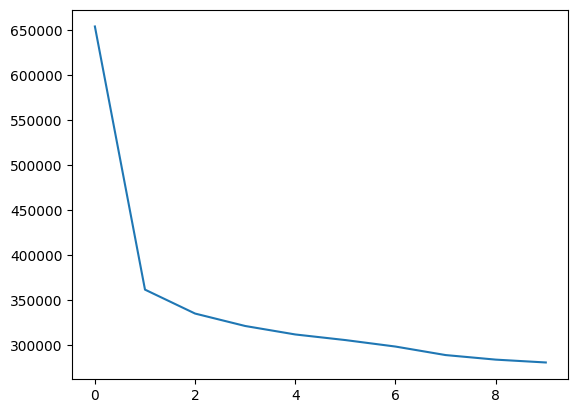

In [11]:
loss_list = []
acc_list = []
train_loader = DatasetLoader(X_train, y_train, batch_size=batch_size)
test_loader = DatasetLoader(X_test, y_test, batch_size=batch_size)

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}')
    loss = 0
    model.train()

    for X, y in tqdm(train_loader, desc='Training'):
        y_pred = model(X, y=y)
        loss += criterion(y, y_pred)
        grad = criterion.backward()
        model.backward(grad)
        optimizer.step()

    correct = 0
    model.eval()

    for X, y in tqdm(test_loader, desc='Testing'):
        y_pred = model(X)
        correct += np.sum(y_pred == y)

    acc = correct / len(y_test)
    acc_list.append(acc)
    loss_list.append(loss)
    print(f'Accuracy: {acc} | Loss: {loss}')

plt.plot(loss_list)
plt.show()

Visualize the model accuracy and loss

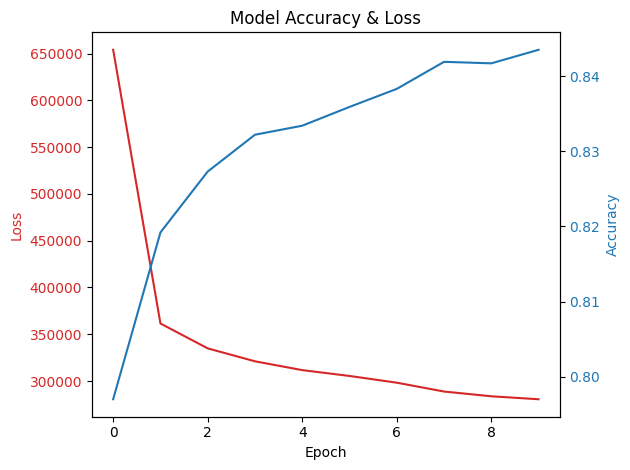

In [28]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Accuracy & Loss')
fig.tight_layout()  
plt.show()

Save the model using Pickle for future inference

In [16]:
save_model(model, 'models/rbf_model_10ep.pkl')

True